In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0: 4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape((1, -1)))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)  # gamma(n)=(n-1)!
# labels 的维度：（n_train+n_test, ）
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# Numpy ndarray 转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.9760],
         [-0.1313]]),
 tensor([[ 1.0000e+00, -1.9760e+00,  1.9522e+00, -1.2858e+00,  6.3518e-01,
          -2.5102e-01,  8.2667e-02, -2.3335e-02,  5.7637e-03, -1.2654e-03,
           2.5004e-04, -4.4916e-05,  7.3960e-06, -1.1242e-06,  1.5867e-07,
          -2.0901e-08,  2.5812e-09, -3.0002e-10,  3.2935e-11, -3.4252e-12],
         [ 1.0000e+00, -1.3132e-01,  8.6229e-03, -3.7746e-04,  1.2392e-05,
          -3.2548e-07,  7.1238e-09, -1.3365e-10,  2.1938e-12, -3.2011e-14,
           4.2038e-16, -5.0187e-18,  5.4923e-20, -5.5482e-22,  5.2043e-24,
          -4.5563e-26,  3.7397e-28, -2.8888e-30,  2.1076e-32, -1.4567e-34]]),
 tensor([-11.2483,   4.5609]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9810033  1.225834  -3.4052474  5.535172 ]]


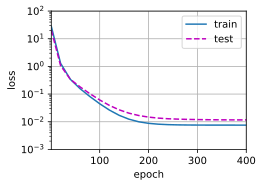

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.928858  4.4892907]]


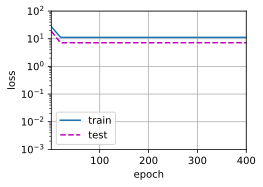

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.970096    1.2991577  -3.3823051   5.148932   -0.05782364  1.1475998
   0.28035036  0.0736725  -0.12347342 -0.07915918 -0.09363931 -0.11123956
  -0.0950877   0.18328637  0.21961933 -0.10639319 -0.07827442  0.10117778
  -0.17476696  0.21865538]]


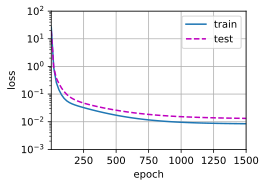

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)